# Twitter User Behavior Analysis for Bot Detection

## Introduction

This Jupyter notebook is dedicated to identifying potential automated accounts (bots) on Twitter by analyzing user behaviors and engagement patterns. The aim is to leverage data-driven insights to distinguish between genuine and inauthentic activities on the platform, helping maintain the quality and authenticity of interactions.

### Objectives

- **Feature Engineering:** Create and refine features from the existing data that may indicate bot-like behavior.
- **Exploratory Data Analysis (EDA):** Visualize and analyze the distribution and relationships of these features to understand typical versus atypical behaviors.
- **Anomaly Detection:** Prepare the groundwork for applying machine learning models to detect outliers which could represent bots.

### Dataset

The dataset is derived from two main tables:
1. `public.twitter_stats`: Contains metrics such as followers, following, posts, likes, and other engagement-related statistics for various Twitter users based on specific search queries.
2. `public.users`: Provides additional user details like screen name, location, account creation date, and description, enhancing the context for each statistical entry from `twitter_stats`.

These tables are joined on user identifiers to form a comprehensive dataset that tracks user engagement and demographics over time, ideal for spotting inconsistencies and anomalies indicative of automated behavior.

### Methodology

We will start by loading and merging the data, followed by cleaning and preprocessing steps to make the data suitable for analysis. After that, we will engineer features that could help identify bots, such as ratios and rates that measure user engagement and activity patterns. The exploratory analysis will involve plotting these features and looking for outliers and patterns. Finally, we'll discuss potential approaches for anomaly detection.

Let's dive into the data to uncover insights and patterns that can help detect and understand bot activities on Twitter.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


import warnings


sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)


# Ensure that the plots are displayed inside the notebook
%matplotlib inline


In [2]:
from packages.database_util import PostgresDatabase

# Initialize database connection using credentials
db = PostgresDatabase(
    host='postgres',
    port=5432,
    database='ope_market',
    user='postgres',
    password='postgres'
)

# Load data from the database
query = """
SELECT 
    ts.search_query,
    ts.followers,
    ts.following,
    ts.posts,
    ts.likes,
    ts.average_daily_likes,
    ts.last_update,
    u.name,
    u.screen_name, 
    u.location, 
    u.created_date, 
    u.description,
    u.links, 
    u.account_age_days, 
    u.last_post_date, CASE WHEN u.verified then 1 else 0 end as verified

FROM public.twitter_stats ts
JOIN public.users u ON u.datasource_id = ts.user_id AND u.datasource = ts.datasource
"""

df = db.fetch_data(query)

## Data Overview

Let's start by examining the first few rows of our DataFrame to understand the structure and content of our data.


In [5]:
df.head(5)


,search_query,followers,following,posts,likes,average_daily_likes,last_update,name,screen_name,location,created_date,description,links,account_age_days,last_post_date,verified
0,fuck trump,445,968,14132,123972,26.86,2021-08-09 14:00:41.130152,Annie🌊Wear A Mask or Casket 🌊,ahmcguffin,close to center in DenialLand,2010-11-18 05:32:48,None,None,4615.0,2021-08-09 13:51:57,0
1,guitar,64,839,13186,34087,8.89,2022-12-01 02:00:52.756261,macoto,mallow_guitar,Green East Village,2013-01-08 04:55:56,None,None,3833.0,2022-12-01 02:00:09,0
2,producer,1630,1601,41003,17170,12.41,2022-08-18 01:00:44.586524,QueenNiShi♠️👸,merealnishi,Somewhere in this beautiful 🌍,2019-09-23 09:38:43,None,"[{'url': 'https://t.co/Qbafej4NtL', 'expanded_...",1384.0,2022-08-18 01:00:04,0
3,blue,131,106,12982,6143,2.00,2022-04-01 19:01:10.757700,fukhed,daveson333,,2015-02-02 22:41:51,None,"[{'url': 'https://t.co/SoCXDx1a1B', 'expanded_...",3078.0,2022-04-01 19:01:03,0
4,Democrat,2105,2206,42120,129148,41.80,2022-04-06 13:01:23.969693,Delaney Gates-Ashli Babbitt died for Trumps Sins,delaney_gates,Oregon Desert,2015-01-21 04:54:12,None,None,3090.0,2022-04-06 13:00:40,0


## Feature Engineering

We will create several new features that might be useful in detecting bots:

1. **Follower to Following Ratio:** Bots might have a skewed ratio compared to normal users.
2. **Engagement Rate:** Defined as likes per post, which might be unusually high or low for bots.
3. **Activity Frequency:** Number of posts divided by account age days to measure how frequently the user posts.
4. **Days Since Last Post:** Time difference between the last post date and the last update to see if there are any irregularities in posting.


In [6]:
# Calculate new features
df['follower_following_ratio'] = df['followers'] / df['following']
df['engagement_rate'] = df['likes'] / df['posts']
df['activity_frequency'] = df['posts'] / df['account_age_days']
df['days_since_last_post'] = (pd.to_datetime(df['last_update']) - pd.to_datetime(df['last_post_date'])).dt.days

# Handle potential infinite or NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)


In [7]:
df.head()

,search_query,followers,following,posts,likes,average_daily_likes,last_update,name,screen_name,location,created_date,description,links,account_age_days,last_post_date,verified,follower_following_ratio,engagement_rate,activity_frequency,days_since_last_post
0,fuck trump,445,968,14132,123972,26.86,2021-08-09 14:00:41.130152,Annie🌊Wear A Mask or Casket 🌊,ahmcguffin,close to center in DenialLand,2010-11-18 05:32:48,0,None,4615.0,2021-08-09 13:51:57,0,0.459711,8.772431,3.062189,0
1,guitar,64,839,13186,34087,8.89,2022-12-01 02:00:52.756261,macoto,mallow_guitar,Green East Village,2013-01-08 04:55:56,0,None,3833.0,2022-12-01 02:00:09,0,0.076281,2.585090,3.440125,0
2,producer,1630,1601,41003,17170,12.41,2022-08-18 01:00:44.586524,QueenNiShi♠️👸,merealnishi,Somewhere in this beautiful 🌍,2019-09-23 09:38:43,0,"[{'url': 'https://t.co/Qbafej4NtL', 'expanded_...",1384.0,2022-08-18 01:00:04,0,1.018114,0.418750,29.626445,0
3,blue,131,106,12982,6143,2.00,2022-04-01 19:01:10.757700,fukhed,daveson333,,2015-02-02 22:41:51,0,"[{'url': 'https://t.co/SoCXDx1a1B', 'expanded_...",3078.0,2022-04-01 19:01:03,0,1.235849,0.473194,4.217674,0
4,Democrat,2105,2206,42120,129148,41.80,2022-04-06 13:01:23.969693,Delaney Gates-Ashli Babbitt died for Trumps Sins,delaney_gates,Oregon Desert,2015-01-21 04:54:12,0,None,3090.0,2022-04-06 13:00:40,0,0.954216,3.066192,13.631068,0


## Exploratory Data Analysis (EDA)

We will visualize these features to understand the distribution and to spot any outliers or patterns that might indicate bot activity.


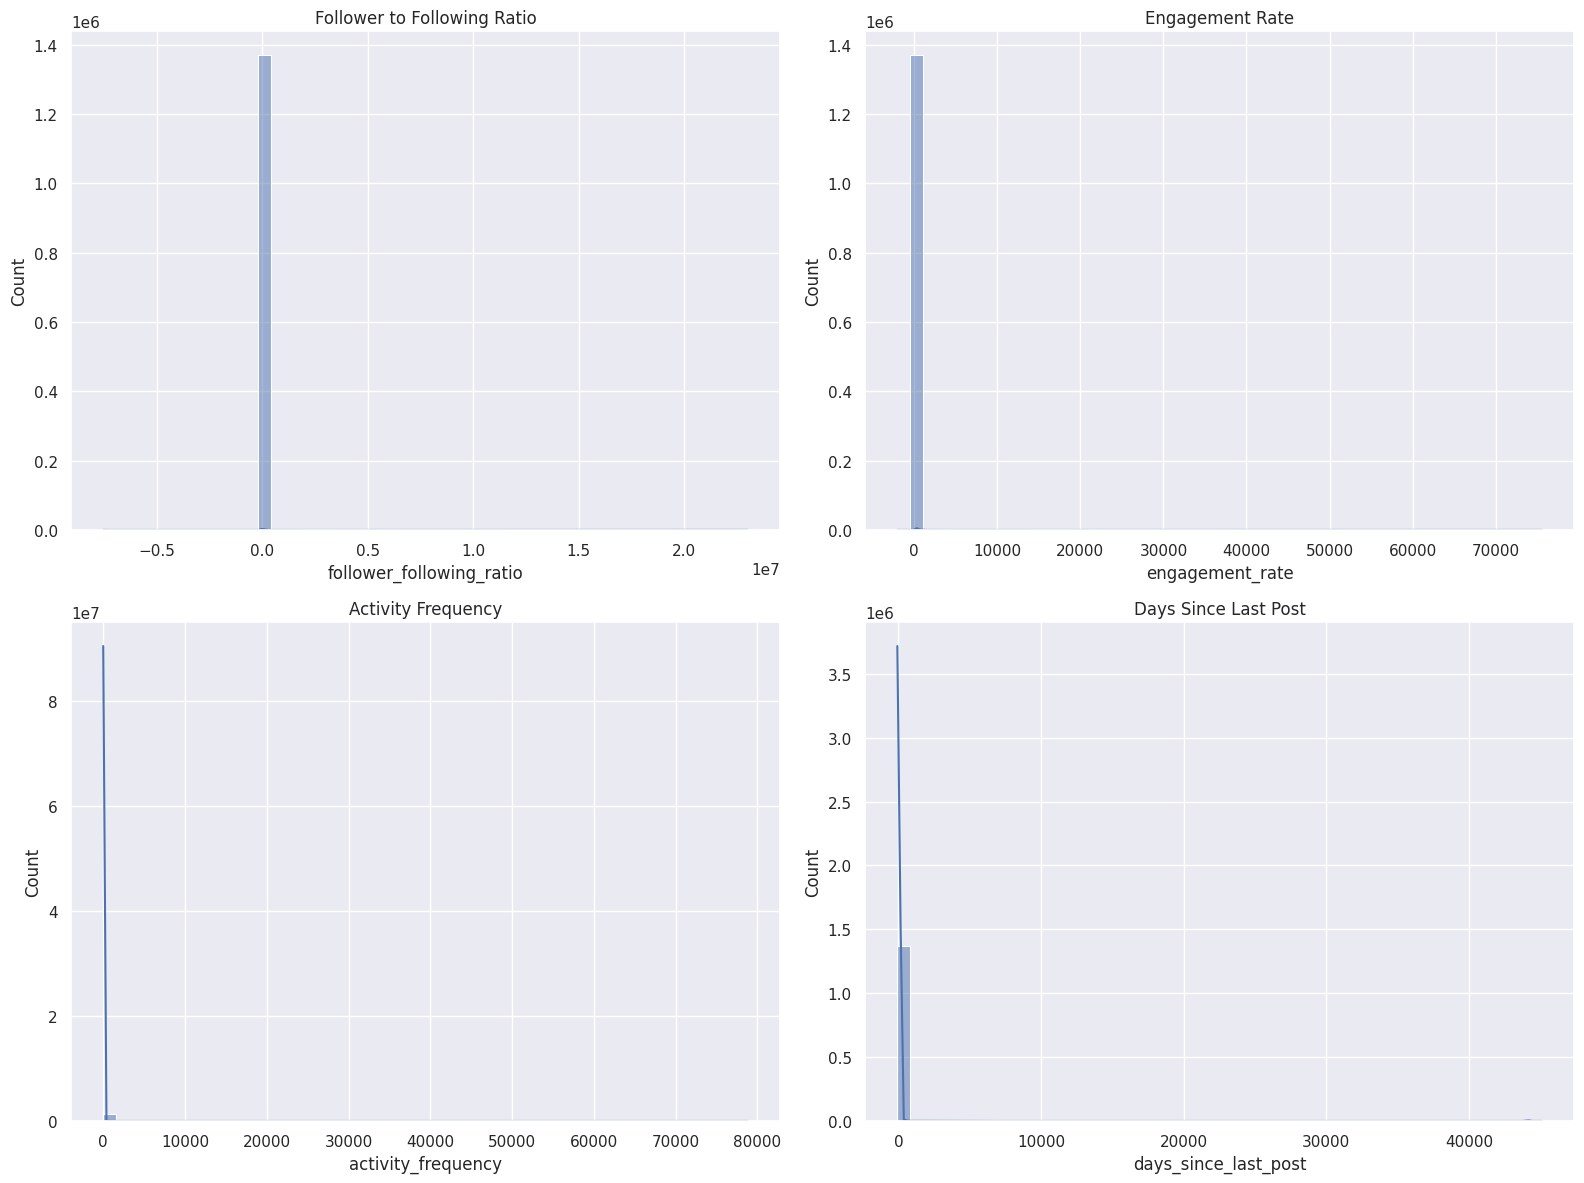

In [8]:
# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Followers to Following Ratio
plt.subplot(2, 2, 1)
sns.histplot(df['follower_following_ratio'], bins=50, kde=True)
plt.title('Follower to Following Ratio')

# Engagement Rate
plt.subplot(2, 2, 2)
sns.histplot(df['engagement_rate'], bins=50, kde=True)
plt.title('Engagement Rate')

# Activity Frequency
plt.subplot(2, 2, 3)
sns.histplot(df['activity_frequency'], bins=50, kde=True)
plt.title('Activity Frequency')

# Days Since Last Post
plt.subplot(2, 2, 4)
sns.histplot(df['days_since_last_post'], bins=50, kde=True)
plt.title('Days Since Last Post')

plt.tight_layout()
plt.show()


# Improving Histogram Visualizations

The initial histograms indicate highly skewed distributions for several features. This skewness compresses most of the data into narrow spikes, making it difficult to discern useful patterns. Below are strategies to enhance these visualizations:

## 1. Log Transformation

Applying a log transformation can help manage the skewness by compressing the scale, which may make the distribution of the data clearer and easier to interpret.


/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


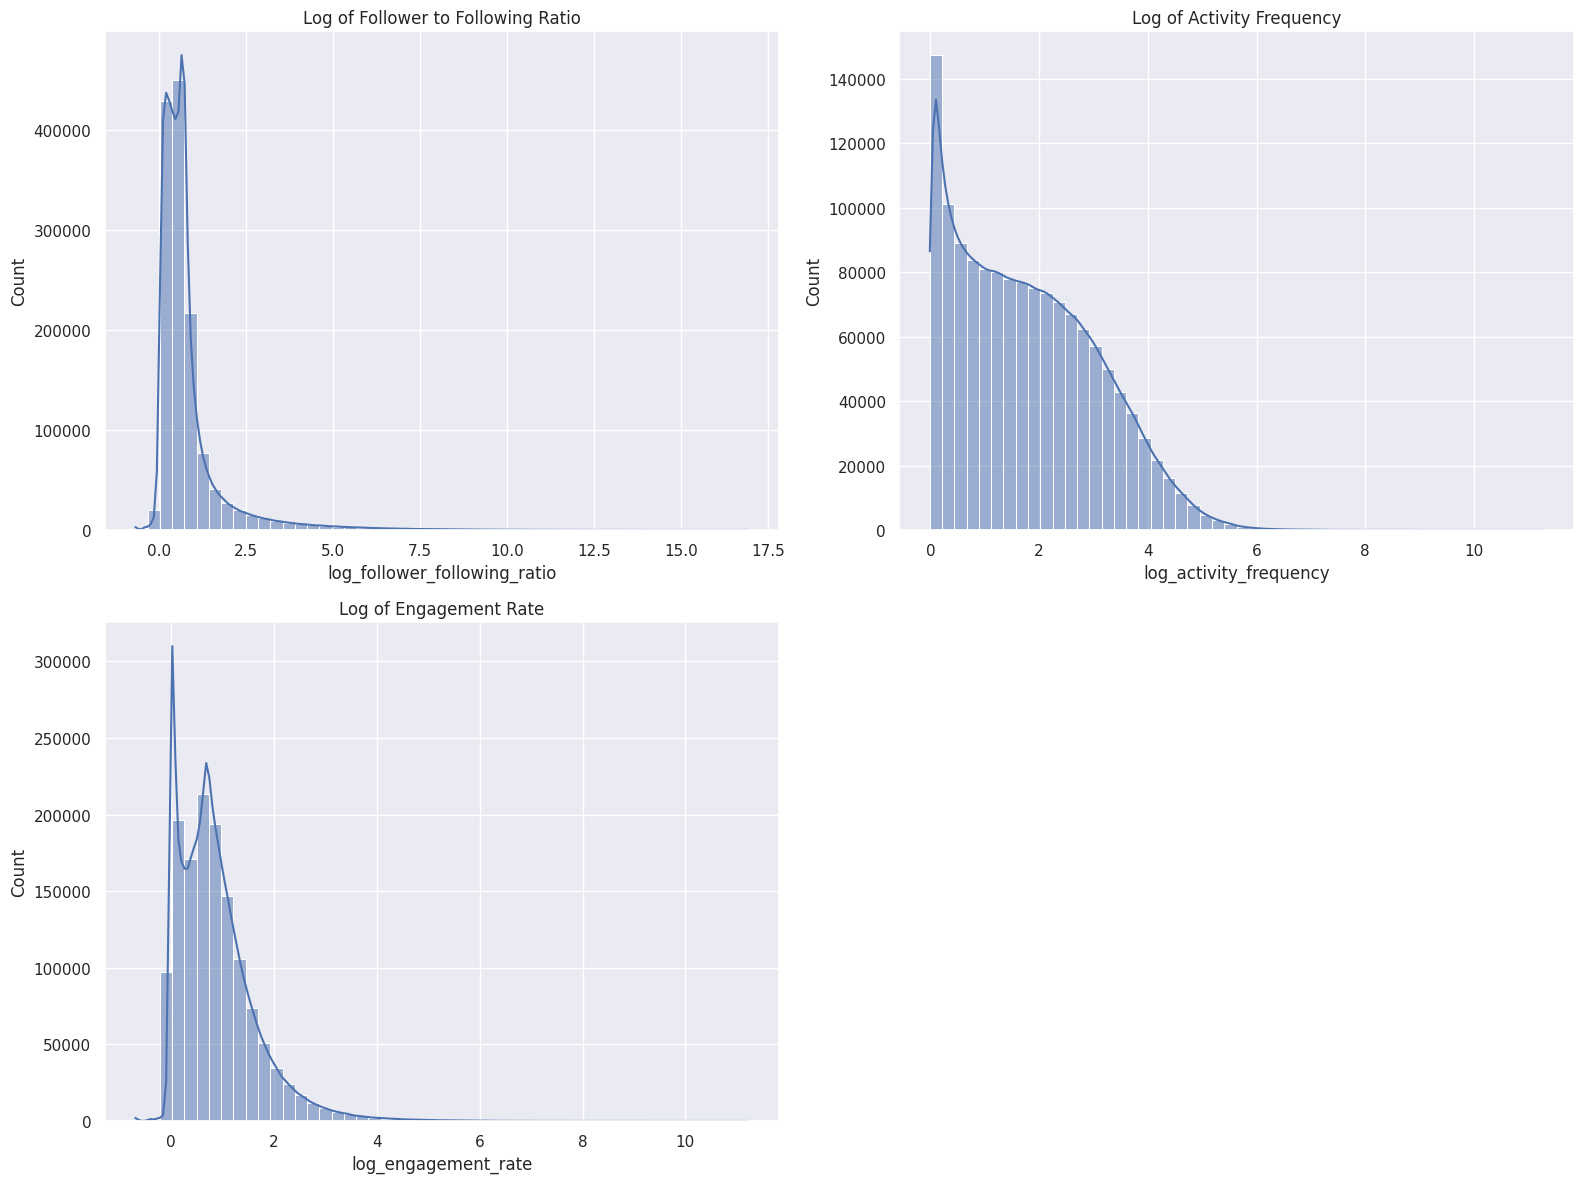

In [9]:
# Applying log transformation to relevant features
df['log_follower_following_ratio'] = np.log1p(df['follower_following_ratio'])
df['log_activity_frequency'] = np.log1p(df['activity_frequency'])
df['log_engagement_rate'] = np.log1p(df['engagement_rate'])

# Plotting the transformed features
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.histplot(df['log_follower_following_ratio'], bins=50, kde=True)
plt.title('Log of Follower to Following Ratio')

plt.subplot(2, 2, 2)
sns.histplot(df['log_activity_frequency'], bins=50, kde=True)
plt.title('Log of Activity Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df['log_engagement_rate'], bins=50, kde=True)
plt.title('Log of Engagement Rate')

plt.tight_layout()
plt.show()

# Refining Log Transformations and Histograms

The initial application of log transformations revealed challenges with zero values and high peaks near zero. We will refine our approach to handle these issues and adjust visualization parameters for clarity.

## Handling Zeros in Data

We will add a small constant to each feature before applying the log transformation to avoid issues with zero values.


/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


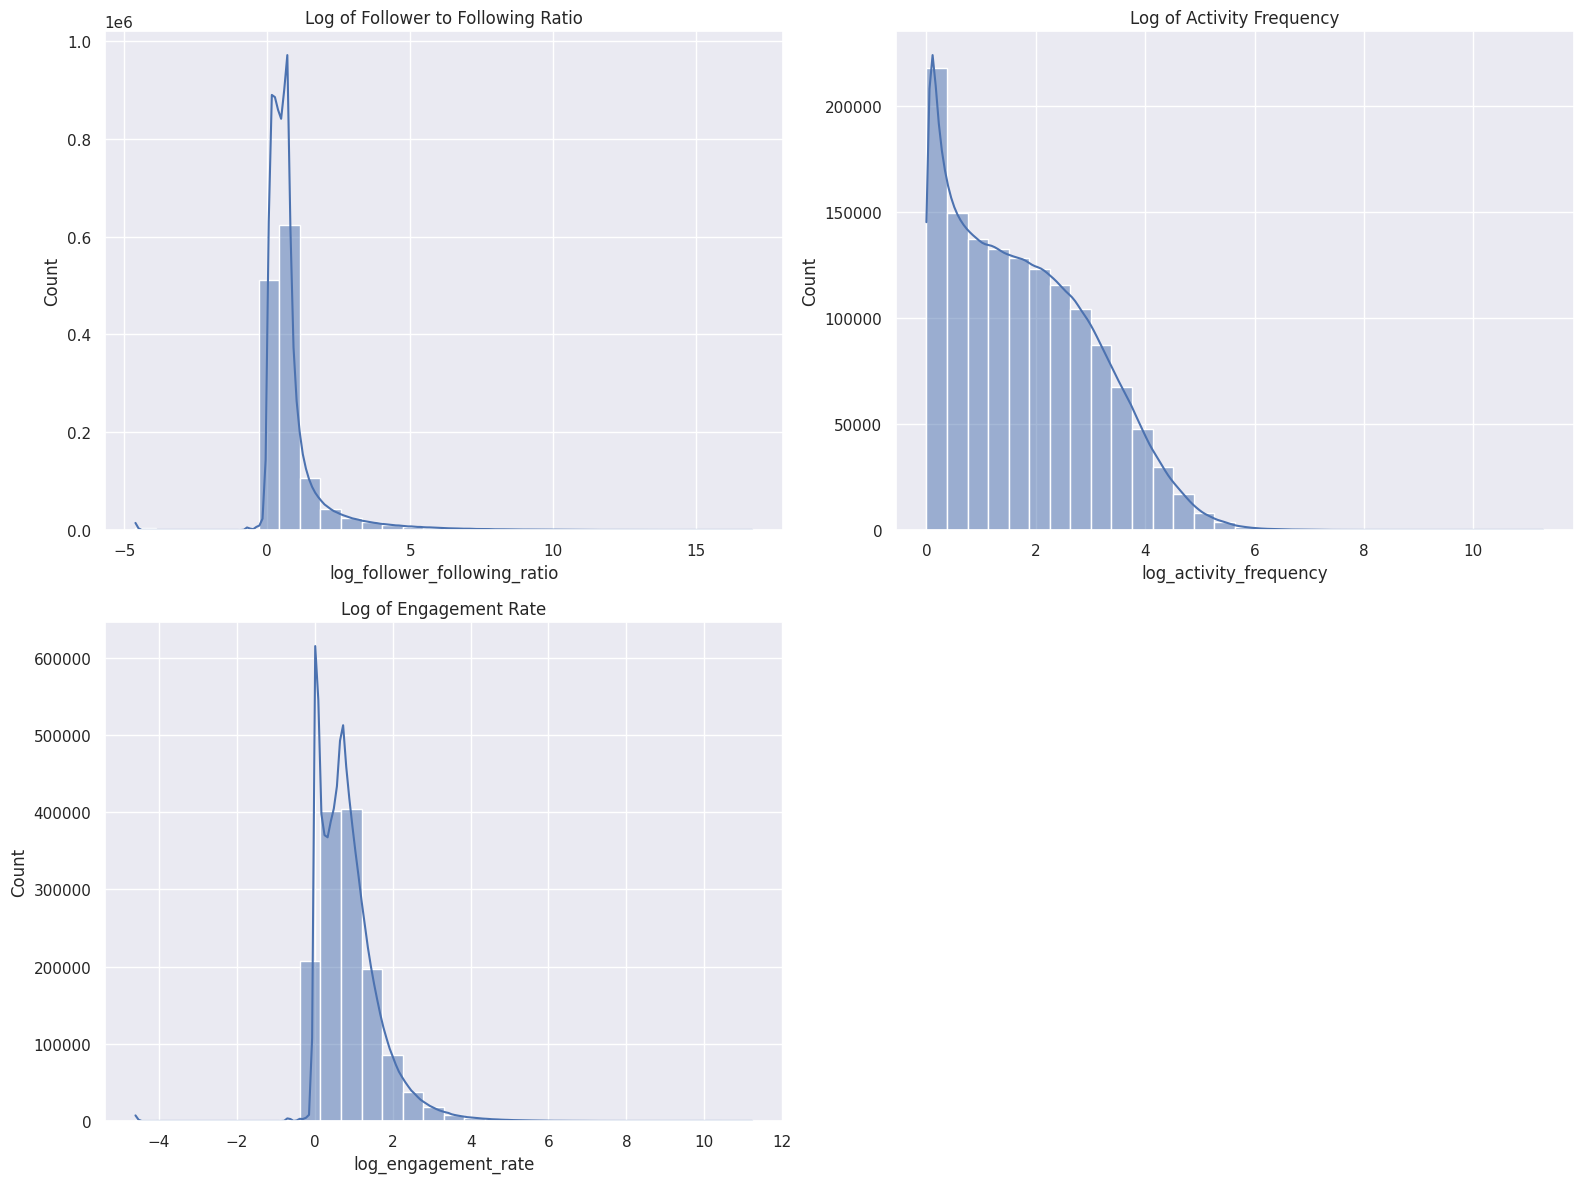

In [10]:
# Adding a small constant before log transformation
df['log_follower_following_ratio'] = np.log1p(df['follower_following_ratio'] + 0.01)
df['log_activity_frequency'] = np.log1p(df['activity_frequency'] + 0.01)
df['log_engagement_rate'] = np.log1p(df['engagement_rate'] + 0.01)

# Replotting the log-transformed features with adjusted bins and range
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.histplot(df['log_follower_following_ratio'], bins=30, kde=True)
plt.title('Log of Follower to Following Ratio')

plt.subplot(2, 2, 2)
sns.histplot(df['log_activity_frequency'], bins=30, kde=True)
plt.title('Log of Activity Frequency')

plt.subplot(2, 2, 3)
sns.histplot(df['log_engagement_rate'], bins=30, kde=True)
plt.title('Log of Engagement Rate')

plt.tight_layout()
plt.show()

# Analysis of Log-Transformed Histograms

The application of log transformations, with a small constant added to each feature, has significantly improved the clarity of the distributions. Below is an analysis of each transformed feature, providing insights into user behaviors and potential indicators of automated accounts (bots).

## Log of Follower to Following Ratio


- **Observation**: The distribution shows a peak at lower values with a long tail extending to higher values.
- **Interpretation**: This suggests most accounts have a relatively balanced follower to following ratio. However, the long tail indicates a subset of accounts with exceptionally high ratios, which could be characteristic of bots or promotional accounts trying to inflate follower numbers.

## Log of Activity Frequency


- **Observation**: There is a decay in count as activity frequency increases, with a steep drop-off after a certain point.
- **Interpretation**: This plot indicates that most users have a moderate level of activity. Accounts showing extremely high levels of activity might be using automation tools, suggesting potential bot behavior.

## Log of Engagement Rate


- **Observation**: The engagement rate also shows a peak at lower values with a long tail toward higher values.
- **Interpretation**: Most users engage at lower rates, which is typical for organic interactions. The outliers with very high engagement rates may be using methods to artificially boost engagement, such as through bots or coordinated campaigns.

## Next Steps for Analysis

- **Outlier Analysis**: With these distributions now clearer, identifying outliers becomes more feasible. Accounts that fall into the long tails of these distributions should be investigated further as they may exhibit bot-like behaviors.
- **Threshold Setting for Anomalies**: Setting thresholds based on these distributions (e.g., beyond the 95th percentile) might help in systematically flagging potential bots for review.
- **Cross-Feature Analysis**: Investigating the relationship between these features can provide deeper insights. For instance, an account with both a high follower-following ratio and a high engagement rate might warrant closer scrutiny.
- **Further Refinement**: If necessary, additional adjustments to the constants used in the log transformations or experimenting with other transformations could further improve the analysis.

This detailed view helps us understand not just typical user behaviors but also highlights patterns that might be indicative of non-genuine activities, aiding in the detection of bots on the platform.


## Implementing the Next Steps for Bot Detection Analysis

Given the insights from the log-transformed histograms and the potential patterns indicating bot behavior, here are the specific methods and techniques we will use to further analyze and potentially flag suspicious accounts.

### Outlier Analysis

Outliers in our dataset could signify accounts that engage in bot-like behavior. We will use statistical methods to identify these outliers:


In [11]:
# Calculate the 95th percentile for each feature
percentile_95_ff_ratio = df['log_follower_following_ratio'].quantile(0.95)
percentile_95_activity = df['log_activity_frequency'].quantile(0.95)
percentile_95_engagement = df['log_engagement_rate'].quantile(0.95)

# Flag accounts that exceed these thresholds
df['outlier_ff_ratio'] = df['log_follower_following_ratio'] > percentile_95_ff_ratio
df['outlier_activity'] = df['log_activity_frequency'] > percentile_95_activity
df['outlier_engagement'] = df['log_engagement_rate'] > percentile_95_engagement

# Combine flags to identify potential bots
df['potential_bot'] = df[['outlier_ff_ratio', 'outlier_activity', 'outlier_engagement']].any(axis=1)

### Threshold Setting for Anomalies
To systematically identify potential bots, we'll set thresholds based on the upper percentiles of the distributions:

In [12]:
# Mark accounts that exceed thresholds in multiple categories as suspicious
df['suspicious'] = df.apply(lambda x: x['outlier_ff_ratio'] and x['outlier_activity'] and x['outlier_engagement'], axis=1)


### Cross-Feature Analysis
Understanding how different features interact can help us better identify complex patterns of bot behavior:

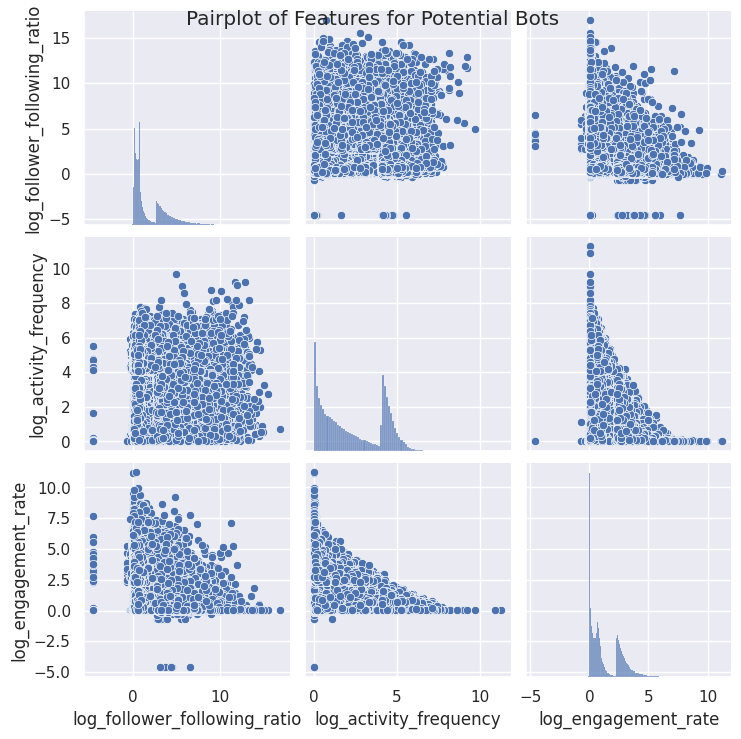

In [13]:
# Plotting correlations among log-transformed features for flagged potential bot accounts
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(df[df['potential_bot']], vars=['log_follower_following_ratio', 'log_activity_frequency', 'log_engagement_rate'], kind='scatter')
plt.suptitle('Pairplot of Features for Potential Bots', verticalalignment='top')
plt.show()


# Cross-Feature Analysis: Understanding Complex Patterns of Bot Behavior

The pairplot generated for the potential bot accounts provides a comprehensive view of how different log-transformed features—follower-following ratio, activity frequency, and engagement rate—interact with each other. Below, we analyze the insights gleaned from this visualization:

## Analysis of Pairplot


### Interaction Between Log Follower-Following Ratio and Other Features:

- **Log Follower-Following Ratio vs. Log Activity Frequency:**
  - **Observation:** A dense cluster with a wide spread in activity frequency at lower ratios, thinning out as the ratio increases.
  - **Interpretation:** Accounts with a very high follower-following ratio tend to have a narrower range of activity frequencies, possibly indicating that extreme ratios are more controlled or artificial.

- **Log Follower-Following Ratio vs. Log Engagement Rate:**
  - **Observation:** Engagement rate decreases as the follower-following ratio increases, with some outliers showing high engagement at lower ratios.
  - **Interpretation:** High engagement rates at lower follower-following ratios might indicate genuine interaction, whereas higher ratios often show lower engagement, possibly signifying less genuine user interaction or automated behavior.

### Interaction Between Log Activity Frequency and Log Engagement Rate:

- **Observation:** There appears to be a negative correlation where higher activity frequencies generally correspond to lower engagement rates.
- **Interpretation:** This pattern suggests that accounts posting very frequently might not be generating proportionate engagement, which could be characteristic of automated posting mechanisms rather than organic content creation.

### Overall Patterns and Outliers:

- **General Trends:** Most accounts cluster in areas indicating moderate to low ratios and frequencies, with a significant number showing low engagement.
- **Outliers:** Notable outliers are those with high activity and low engagement, high ratios with any level of engagement, and low ratios with unusually high engagement.

## Implications for Bot Detection:

This cross-feature analysis highlights specific profiles that might warrant further investigation:
1. **High Ratio and Low Engagement:** Likely bots or promotional accounts.
2. **High Frequency and Low Engagement:** Potentially automated content posting.
3. **Low Ratio and High Engagement:** While often indicative of genuine activity, unusually high metrics in this zone could suggest sophisticated bots designed to mimic real user behavior.

## Further Steps:

- **Detailed Investigation of Outliers:** Accounts that significantly deviate from common patterns should be manually reviewed to confirm if they are bots.
- **Model Refinement:** These insights can be used to refine machine learning models for bot detection, potentially incorporating these feature interactions as inputs to improve accuracy.

By analyzing how different features related to Twitter user behavior interact, we can better identify complex patterns that might indicate bot activity, helping to enhance the effectiveness of automated detection systems.


# Model Development for Bot Detection

This section details the steps for developing a machine learning model to detect potential bots based on the identified features. We'll use an unsupervised learning approach due to the absence of labeled data.

## Feature Selection

We'll select features based on their potential to indicate bot behavior as observed in the pairplot and other EDA steps. 


In [19]:
# Selecting features based on EDA insights
features = ['log_follower_following_ratio', 'log_activity_frequency', 'log_engagement_rate']



X = df[features]

# Handling Missing Data

Before training the model, it's essential to handle missing values in our dataset.
## Imputing Missing Values

We can use the SimpleImputer from sklearn to replace missing values with the median value of each column. This approach is beneficial if the missing data is not significantly large and appears randomly distributed across observations.



In [21]:
from sklearn.impute import SimpleImputer

# Creating an imputer object to replace missing values with the median of each column
imputer = SimpleImputer(strategy='median')

# Applying the imputer to our selected features
X_imputed = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed, columns=features)

## Model Choice: Isolation Forest
Given the lack of labels and the need to detect outliers (potential bots), an Isolation Forest is a suitable choice. This model is effective in identifying anomalies in the data.

In [22]:
from sklearn.ensemble import IsolationForest

# Setting up the Isolation Forest model
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)


# Fitting the model to the data
model.fit(X_imputed)


IsolationForest(random_state=42)

### Predicting and Visualizing Anomalies
Post-training, let's predict anomalies and visualize where our model identifies potential bots.

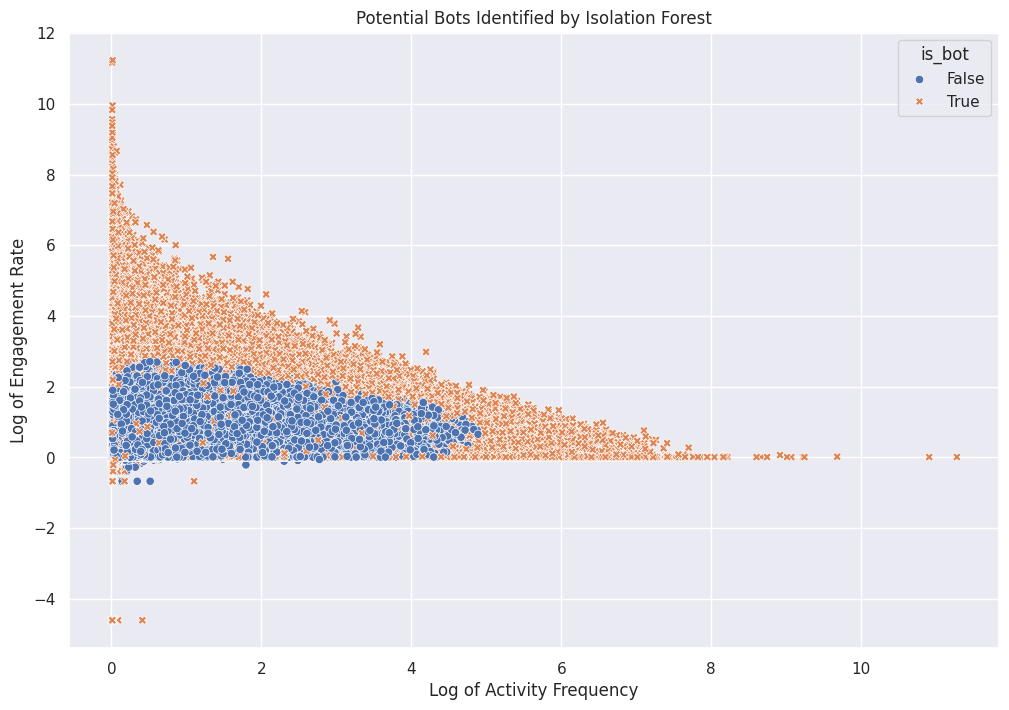

In [24]:
# Predicting anomalies
df['anomaly'] = model.predict(X_imputed)
df['is_bot'] = df['anomaly'] == -1

import seaborn as sns
import matplotlib.pyplot as plt

# Visualizing the results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='log_activity_frequency', y='log_engagement_rate', hue='is_bot', style='is_bot', markers=['o', 'X'])
plt.title('Potential Bots Identified by Isolation Forest')
plt.xlabel('Log of Activity Frequency')
plt.ylabel('Log of Engagement Rate')
plt.show()


# Analysis of Scatter Plot: Identifying Potential Bots

The scatter plot visualizes the relationship between 'Log of Activity Frequency' and 'Log of Engagement Rate', categorizing accounts as either potential bots (`True`, marked with 'x') or not (`False`, marked with circles). This analysis provides insights into the behaviors that differentiate suspected bots from typical users.

## Distribution of Points

- **General Observation**: Most accounts (marked as circles) are clustered around the lower ends of both axes, indicating low activity frequency and engagement rates for the majority of users.
- **Potential Bots**: Accounts flagged as potential bots (marked with 'x') typically exhibit higher values on both axes and are more dispersed, suggesting varied bot-like activities.

## Characteristics of Potential Bots

- **Engagement and Activity**: Many of the accounts labeled as potential bots show higher engagement rates compared to most non-bot accounts. This suggests that bots may be designed to foster interactions to mimic or stimulate user engagement.
- **Wide Range of Activity**: Bots are not only active in high engagement and activity areas but are also present across a broad spectrum of the axes, indicating diverse operational strategies.

## Areas of Interest

- **Upper-Right Quadrant**: This area, where both activity and engagement rates are high, contains a significant concentration of potential bots. It represents a key region for further investigation due to the suspected high intensity of automated behavior.
- **Isolated Bots**: Some potential bots appear in areas with lower activity or engagement, highlighting that some bots operate under less conspicuous profiles, possibly to avoid detection.

## Conclusions and Implications

- **High Activity and Engagement**: The strong presence of potential bots in regions of high activity and engagement underscores the need for platforms to scrutinize such accounts closely, as they are likely to be automating interactions.
- **Bot Strategy Diversity**: The variety in bot activity levels and engagement rates suggests multiple types of automated strategies, ranging from aggressive engagement bots to more passive, stealthy accounts.
- **Model Evaluation**: The model's ability to flag a diverse range of bot-like behaviors indicates its utility, though the overlap of behaviors with genuine users suggests that fine-tuning and additional features might improve its accuracy.
- **Manual Review Necessity**: Given the overlap and potential for false positives, manually reviewing flagged accounts is crucial to refine detection criteria and understand the nuances of bot behaviors better.

This analysis not only aids in understanding the landscape of automated accounts but also supports the ongoing refinement of detection methods to better distinguish between genuine and automated behaviors.
